# ArchPy2Modflow: Energy Transport with Modflow 6

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import geone.imgplot3d as imgplt3
import pyvista as pv
import sys
import os

# auto reload modules
%load_ext autoreload
%autoreload 2

sys.path.append("../../")
#my modules
from ArchPy.base import *
from ArchPy.tpgs import *

In [2]:
#grid
sx = 1.5
sy = 1.5
sz = .15
x0 = 0
y0 = 0
z0 = -15
nx = 100
ny = 50
nz = 50
x1 = x0 + nx*sx
y1 = y0 + ny*sy
z1 = z0 + nz*sz

dimensions = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (x0, y0, z0)  

In [3]:
## create pile

P1 = Pile(name = "P1",seed=1)

#units covmodel
covmodelD = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodelD1 = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[30,30]})])
covmodelC = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[40,40]})])
covmodelB = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodel_er = gcm.CovModel2D(elem=[('spherical', {'w':1, 'r':[50,50]})])

# facies covmodels
covmodel_f_B = gcm.CovModel3D(elem=[('spherical', {'w':.25, 'r':[20, 20, 2]})])

#create Lithologies 
dic_s_D = {"int_method" : "grf_ineq","covmodel" : covmodelD}
dic_f_D = {"f_method":"homogenous"}
D = Unit(name="D",order=1,ID = 1,color="gold",contact="onlap",surface=Surface(contact="onlap",dic_surf=dic_s_D)
         ,dic_facies=dic_f_D)

dic_s_C = {"int_method" : "grf_ineq","covmodel" : covmodelC, "mean":-8.5}
dic_f_C = {"f_method":"homogenous"}
C = Unit(name="C", order=2, ID = 2, color="blue", contact="onlap", dic_facies=dic_f_C, surface=Surface(dic_surf=dic_s_C, contact="onlap"))

dic_s_B = {"int_method" : "grf_ineq","covmodel" : covmodelB, "mean":-9.5}
dic_f_B = {"f_method":"SIS", "f_covmodel":[covmodel_f_B], "probability":[0.3, 0.6, 0.1]}
B = Unit(name="B",order=3,ID = 3,color="purple",contact="onlap",dic_facies=dic_f_B,surface=Surface(contact="onlap",dic_surf=dic_s_B))

dic_s_A = {"int_method":"grf_ineq","covmodel": covmodelB, "mean":-13}
dic_f_A = {"f_method":"homogenous"}
A = Unit(name="A",order=4, ID = 4,color="red",contact="onlap",dic_facies=dic_f_A,surface=Surface(dic_surf = dic_s_A,contact="onlap"))

#Master pile
P1.add_unit([D,C,B,A])

Unit D: Surface added for interpolation
Unit C: Surface added for interpolation
Unit B: Surface added for interpolation
Unit A: Surface added for interpolation
Stratigraphic unit D added
Stratigraphic unit C added
Stratigraphic unit B added
Stratigraphic unit A added


In [4]:
# covmodels for the property model
covmodelK = gcm.CovModel3D(elem=[("exponential",{"w":0.3,"r":[30,30,10]})],alpha=-20,name="K_vario")
covmodelK2 = gcm.CovModel3D(elem=[("spherical",{"w":0.1,"r":[20,20, 5]})],alpha=0,name="K_vario_2")

facies_1 = Facies(ID = 1,name="Sand",color="yellow")
facies_2 = Facies(ID = 2,name="Gravel",color="lightgreen")
facies_4 = Facies(ID = 4,name="Clay",color="blue")
facies_7 = Facies(ID = 7,name="basement",color="red")

A.add_facies([facies_7])
B.add_facies([facies_1, facies_2, facies_4])
D.add_facies([facies_1])
C.add_facies([facies_4])

# property model

# K
# cm_prop1 = gcm.CovModel3D(elem = [("spherical", {"w":0.5, "r":[10, 10, 10]}),
#                                   ("cubic", {"w":0.5, "r":[15, 15, 15]})])
cm_prop2 = gcm.CovModel3D(elem = [("cubic", {"w":0.5, "r":[25, 25, 25]})])

list_facies = [facies_1, facies_2, facies_4, facies_7]
means = [-4, -2, -8, -10]
prop_model = ArchPy.base.Prop("K",
                              facies = list_facies,
                              covmodels = [cm_prop2, cm_prop2, cm_prop2, cm_prop2],
                                means = means,
                                int_method = ["sgs", "sgs", "sgs", "homogenous"],
                                vmin = -10,
                                vmax = -1
                                )

# porosity
cm_prop1 = gcm.CovModel3D(elem = [("spherical", {"w":0.01, "r":[10, 10, 10]})])
cm_prop2 = gcm.CovModel3D(elem = [("cubic", {"w":0.01, "r":[15, 15, 15]})])

porosity = ArchPy.base.Prop("Porosity",
                            facies = list_facies,
                            covmodels = [cm_prop2, cm_prop2, cm_prop2, cm_prop2],
                            means = [0.2, 0.3, 0.3, 0.05],
                            int_method = ["sgs", "sgs", "sgs", "homogenous"],
                            vmin = 0,
                            vmax = 0.4
                            )

Facies basement added to unit A
Facies Sand added to unit B
Facies Gravel added to unit B
Facies Clay added to unit B
Facies Sand added to unit D
Facies Clay added to unit C


In [5]:
top = np.ones([ny,nx])*z1
bot = np.ones([ny,nx])*z0

In [6]:
T1 = Arch_table(name = "P1",seed=3)
T1.set_Pile_master(P1)
T1.add_grid(dimensions, spacing, origin, top=top,bot=bot)
T1.add_prop([prop_model, porosity])

Pile sets as Pile master
## Adding Grid ##
## Grid added and is now simulation grid ##
Property K added
Property Porosity added


In [7]:
T1.get_sp(facies_kws=["probability"])[0]

,name,contact,int_method,filling_method,list_facies,probability
0,D,onlap,grf_ineq,homogenous,[Sand],None
1,C,onlap,grf_ineq,homogenous,[Clay],None
2,B,onlap,grf_ineq,SIS,"[Sand, Gravel, Clay]","[0.3, 0.6, 0.1]"
3,A,onlap,grf_ineq,homogenous,[basement],None


In [8]:
T1.get_sp()[1]

,name,property,mean,covmodels
0,Sand,K,-4.000000,"0: cub (w: 0.5, r: [25, 25, 25])"
1,Sand,Porosity,0.200000,"0: cub (w: 0.01, r: [15, 15, 15])"
2,Clay,K,-8.000000,"0: cub (w: 0.5, r: [25, 25, 25])"
3,Clay,Porosity,0.300000,"0: cub (w: 0.01, r: [15, 15, 15])"
4,Gravel,K,-2.000000,"0: cub (w: 0.5, r: [25, 25, 25])"
5,Gravel,Porosity,0.300000,"0: cub (w: 0.01, r: [15, 15, 15])"
6,basement,K,-10.000000,"0: cub (w: 0.5, r: [25, 25, 25])"
7,basement,Porosity,0.050000,"0: cub (w: 0.01, r: [15, 15, 15])"


In [9]:
T1.compute_surf(1)
T1.compute_facies(1)
T1.compute_prop(1)

Boreholes not processed, fully unconditional simulations will be tempted
########## PILE P1 ##########
Pile P1: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.014959573745727539 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.01496124267578125 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.013962268829345703 s

#### COMPUTING SURFACE OF UNIT D
D: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.04538536071777344 s
##########################


### 0.0987546443939209: Total time elapsed for computing surfaces ###

### Unit D: facies simulation with homogenous method ####
### Unit D - realization 0 ###
Time elapsed 0.0 s

### Unit C: facies simulation with homogenous method ####
### Unit C - realization 0 ###
Time elapsed 0.0 s

### Unit B: facies simulation with SIS method ####
### Unit B - realization 0 ###

In [10]:
pv.set_jupyter_backend("static")

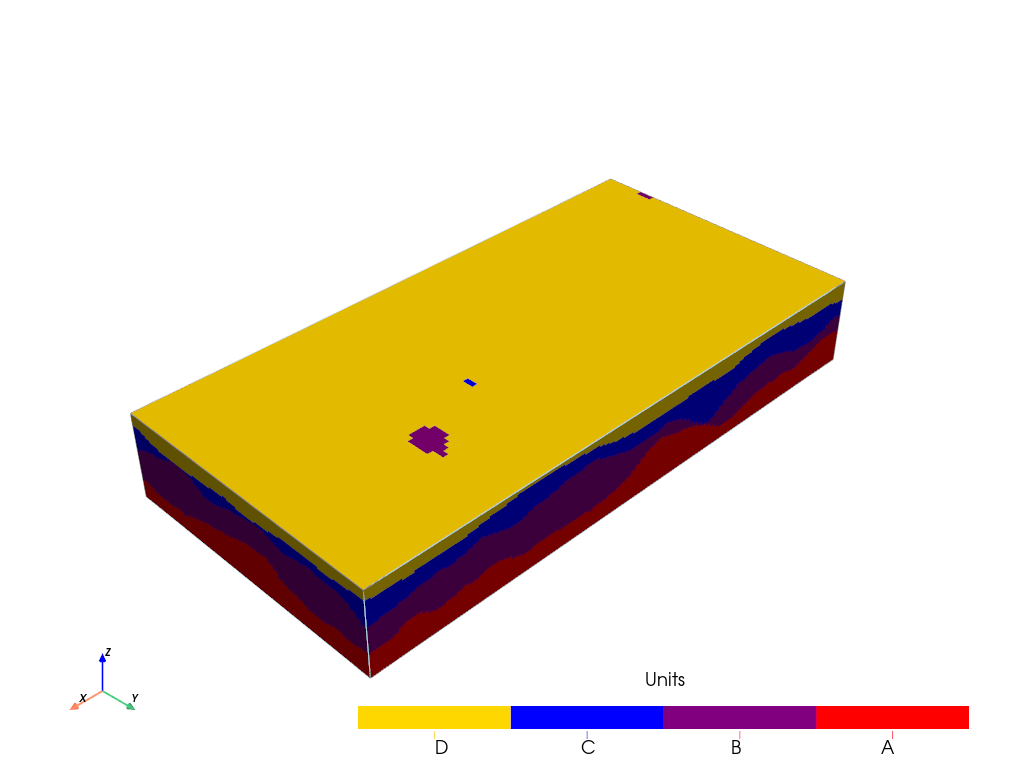

In [11]:
T1.plot_units(v_ex=3)

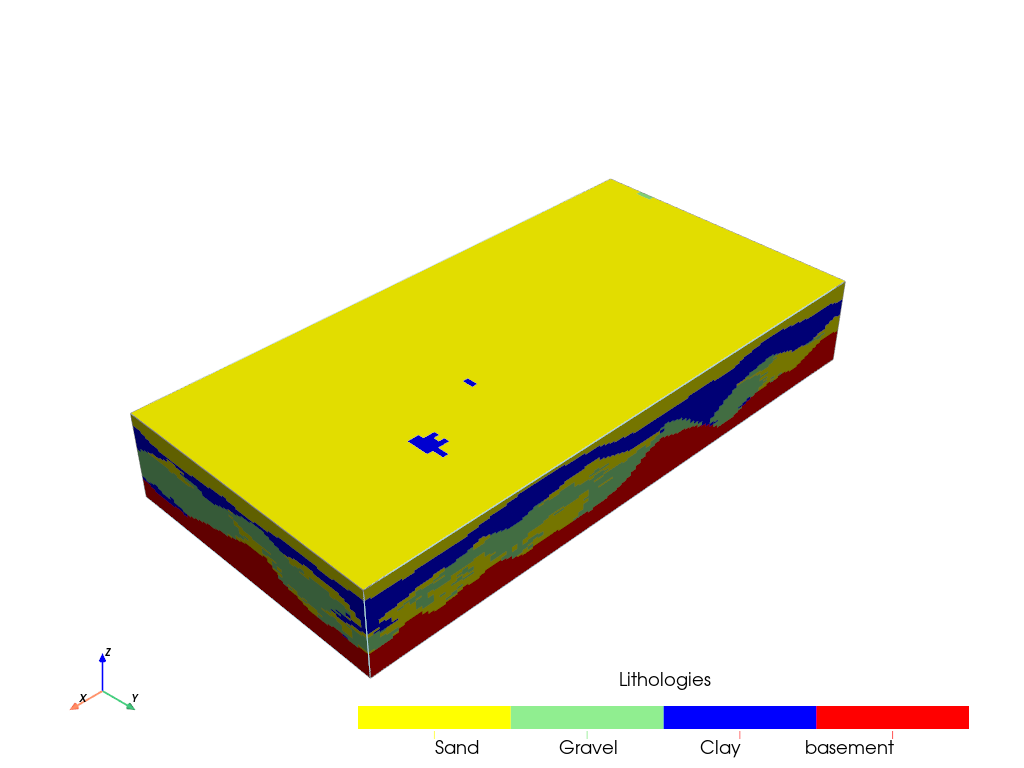

In [12]:
T1.plot_facies(v_ex=3)

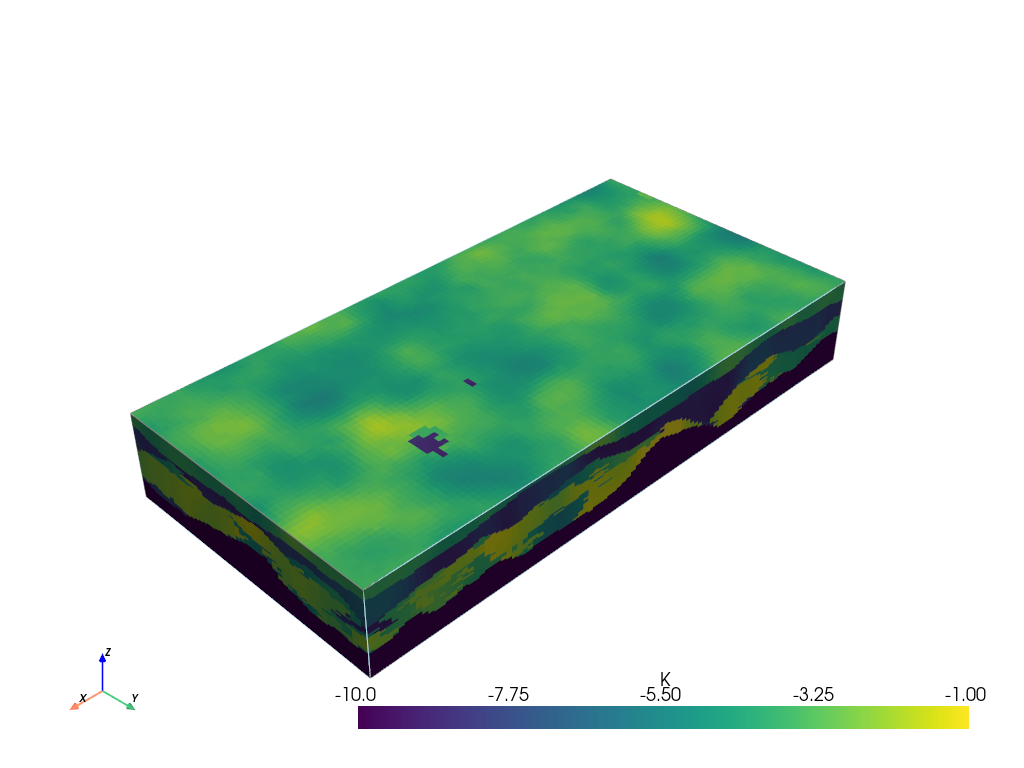

In [13]:
T1.plot_prop("K", v_ex=3)

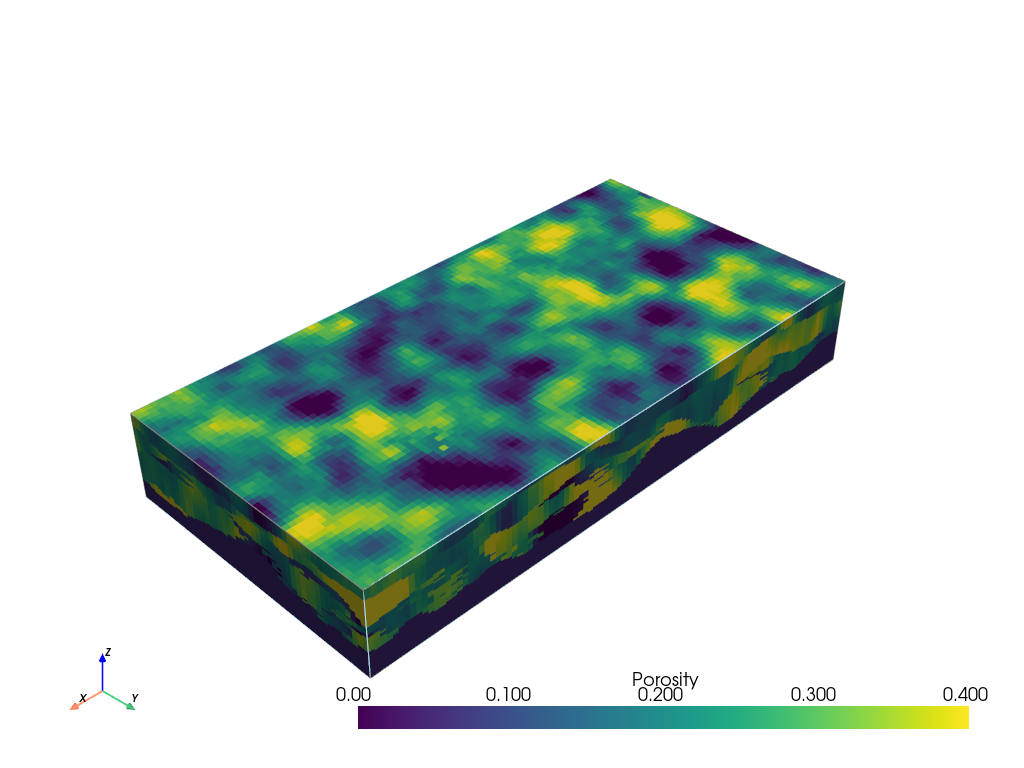

In [14]:
T1.plot_prop("Porosity", v_ex=3)

### Flow model

In [15]:
import ArchPy.ap_mf
from ArchPy.ap_mf import archpy2modflow, array2cellids

In [16]:
mf6_exe_path = "../../../../exe/mf6.exe"

In [17]:
archpy_flow = archpy2modflow(T1, exe_name=mf6_exe_path)  # create the modflow model
archpy_flow.create_sim(grid_mode="layers", iu=0, unit_limit=None, lay_sep=[1, 1, 3, 1], factor_x=2, factor_y=2, factor_z=2)  # create the simulation object and choose a certain discretization
archpy_flow.set_k("K", iu=0, ifa=0, ip=0, log=True, k_average_method="anisotropic")  # set the hydraulic conductivity

Simulation created
To retrieve the simulation, use the get_sim() method


In [18]:
Porosity_up = archpy_flow.upscale_prop("Porosity")

In [19]:
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()

In [20]:
import flopy as fp

In [21]:
sim.ims.remove()
inner_dvclose = 1e-5
ims = fp.mf6.ModflowIms(sim, complexity="moderate", inner_dvclose=inner_dvclose)

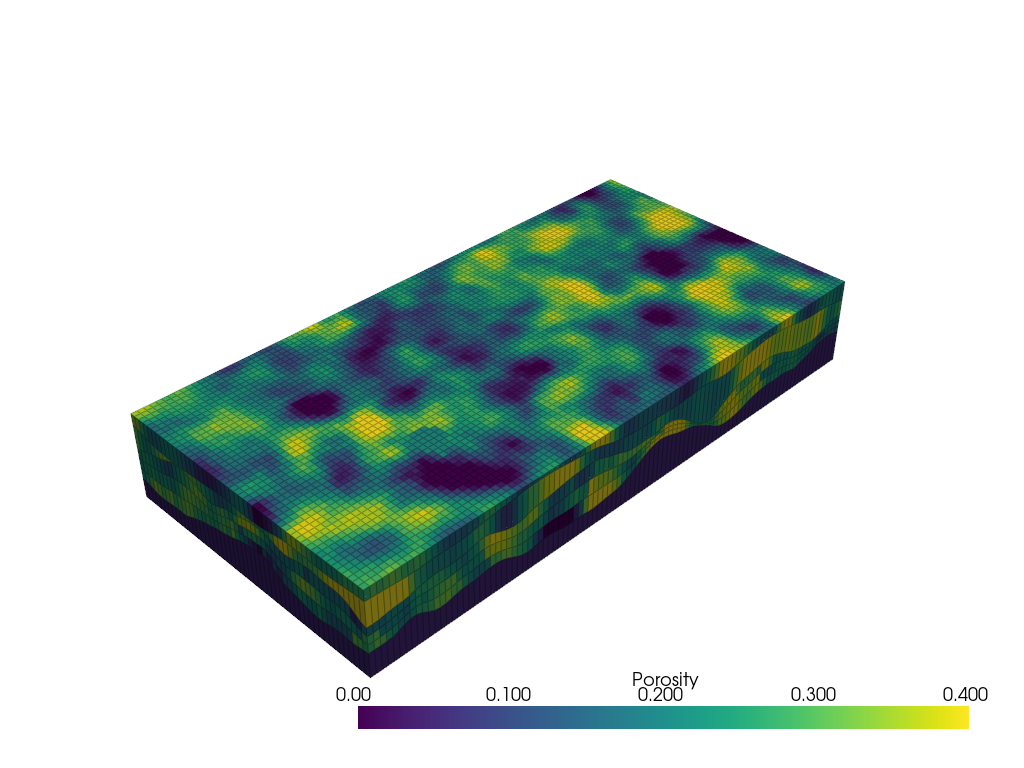

In [22]:
from flopy.export.vtk import Vtk

vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

vtk.add_array(np.log10(gwf.npf.k.array), name="K")
vtk.add_array(Porosity_up, name="Porosity")
vtk.add_array(gwf.dis.idomain.array, name="IDOMAIN")
gwf_mesh = vtk.to_pyvista()

ghosts = np.argwhere(gwf_mesh["K"] > 1)
gwf_mesh.remove_cells(ghosts, inplace=True)

pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="Porosity", cmap="viridis", edge_opacity=0.3)
pl.show()

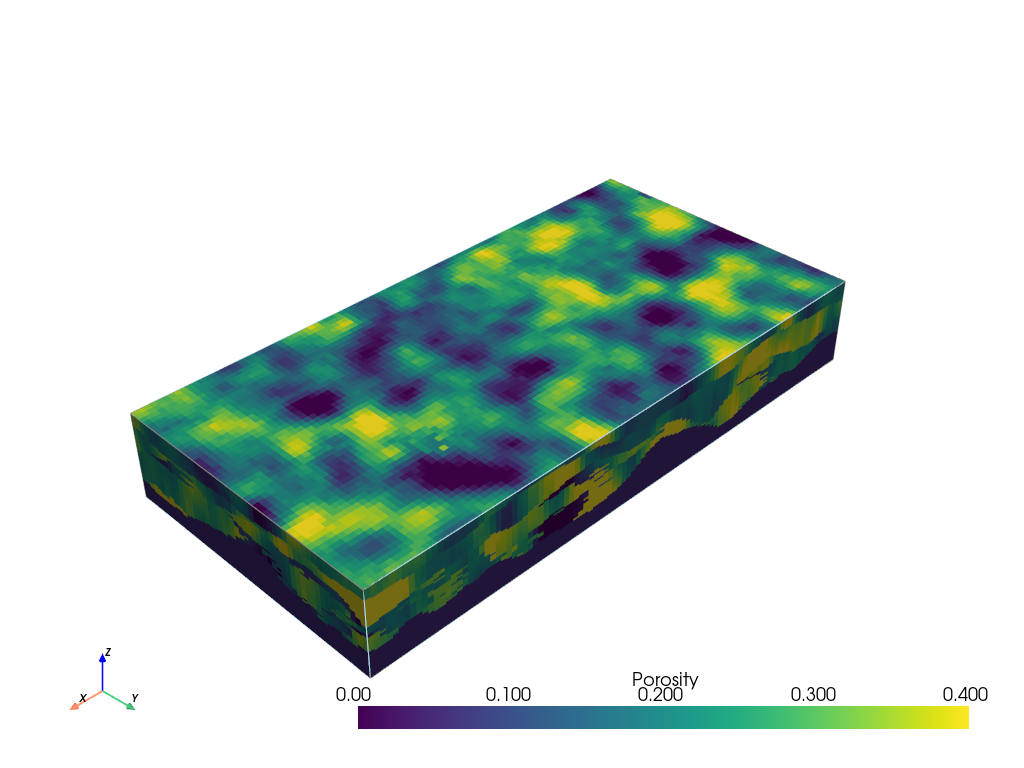

In [23]:
T1.plot_prop("Porosity", v_ex=3)

In [24]:
import flopy as fp

In [25]:
# add BC at left and right on all layers
h1 = .3
h2 = 0
chd_data = []

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, 0] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h1))

chd1 = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True, pname="CHD-1")

chd_data = []
a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, -1] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h2))

chd2 = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True, pname="CHD-2")

In [26]:
# add an injection well in the middle of the model
well_data = []
Q_well = 0.001  # m3/s
C_well = 10  # Concentration at injection well
cellid_well = (2, T1.ny // 2, T1.nx // 2)
well_data.append((cellid_well, Q_well, C_well))
wel = fp.mf6.ModflowGwfwel(gwf, stress_period_data=well_data, save_flows=True, auxiliary="Concentration", pname="WEL-INJ", print_flows=True, print_input=True)

# # production well
# well_data = []
# Q_well = -0.001  # m3/s
# cellid_well = (2, T1.ny // 2, T1.nx // 3)
# well_data.append((cellid_well, Q_well))
# wel = fp.mf6.ModflowGwfwel(gwf, stress_period_data=well_data, save_flows=True, pname="WEL-PROD")

In [27]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package chd-1...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 290 based on size of stress_period_data
    writing package chd-2...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 300 based on size of stress_period_data
    writing package wel-inj...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.1 02/10/2025

   MODFLOW 6 compiled Feb 14 2025 13:40:10 with Intel(R)

(True, [])

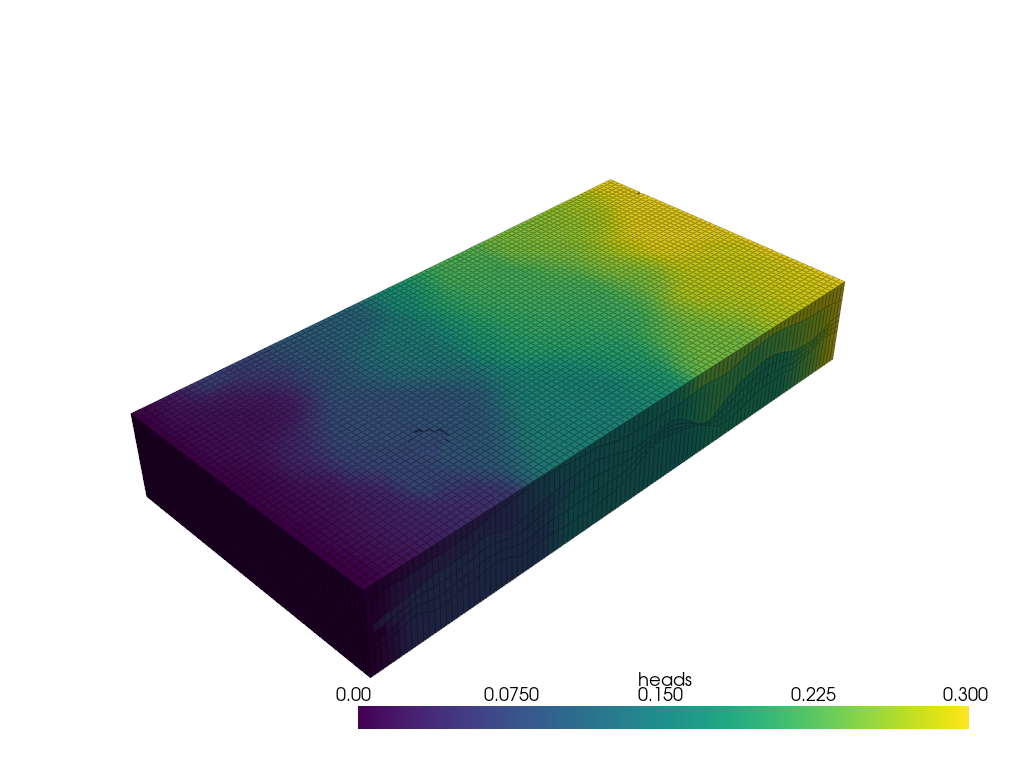

In [28]:
from flopy.export.vtk import Vtk

vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

heads = archpy_flow.get_heads()
vtk.add_array(heads, name="heads")
vtk.add_array(np.log10(gwf.npf.k.array), name="K")

gwf_mesh = vtk.to_pyvista()
ghosts = np.argwhere(gwf_mesh["idomain"] <= 0)
gwf_mesh.remove_cells(ghosts, inplace=True)

pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="heads", cmap="viridis", edge_opacity=0.3)
pl.show()

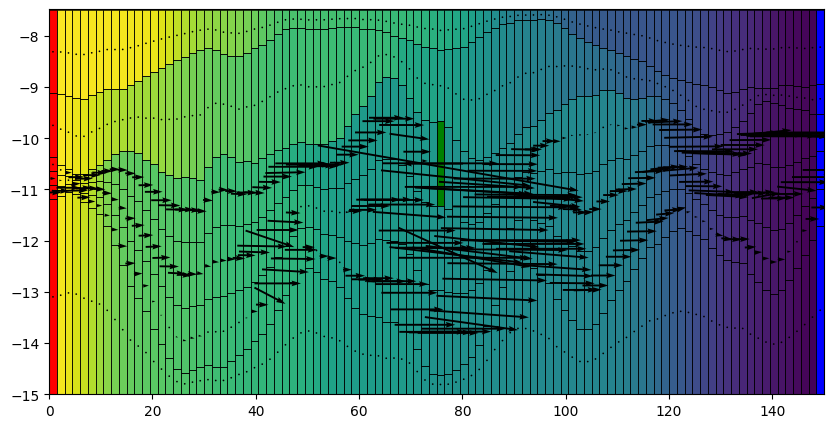

In [29]:
cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

# plot cross section
from flopy.plot import PlotCrossSection
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cross_section = PlotCrossSection(model=gwf, line={"row": 25})
# cross_section.plot_array(np.log10(gwf.npf.k.array), cmap="Blues", ax=ax)
cross_section.plot_array(heads, cmap="viridis", ax=ax)
cross_section.plot_bc("CHD-1", color="red", ax=ax)
cross_section.plot_bc("CHD-2", color="blue", ax=ax)
cross_section.plot_bc("WEL-INJ", color="green", ax=ax)
cross_section.plot_vector(qx, qy, qz, color="black", normalize=False)
cross_section.plot_grid(linewidth=0.5, color="black")

### Transport model

A basic transport model can be created using the method "create_sim_transport". Several parameters can be specified such as molecular diffusivity, sorption, and the porosity of the solid. More parameters can be specified once simulation is created using dedicated set functions such as ``set_porosity`` or ``set_mst``.

When these methods are called, it is possible to either provide, for each parameter, a single value (homogenous), an array-like object of values of the size of the model (e.g., (nlay, nrow, ncol) if the model use a structured grid) or a string, indicating the 
ArchPy property name to use for this parameter.

In [30]:
archpy_flow.create_sim_transport(strt_conc=0.0, porosity=0.2, diff=1e-9, 
                                 adv_scheme="upstream",
                                 alh=None, ath1=None,
                                 decay=None, decay_0=False, decay_1=False)

In [31]:
archpy_flow.set_porosity(prop_key="Porosity", iu=0, ifa=0, ip=0)

To set specific parameters for the dispersion, we can use the method ``set_dsp``. You can provide dispersivity coefficients, molecular diffusion as well as deactivating the xt3d option for faster (but less accurate) simulations

In [32]:
archpy_flow.set_dsp(xt3d_off=True)

dsp package updated


To set parameters for the decaying of the solute, it is necessary to use the mst package. Values can be modified with ``set_mst`` method

In [33]:
archpy_flow.set_mst(decay=1e-5, decay_1=True)  # add a decay of 1e-5 g/m^3/s

mst package updated


A source sinking-mixing package needs to be defined as a BC has been defined with an auxiliary variable

In [34]:
# set links between the flow and energy models (ssm package)
sourcerecarray = [
    ("WEL-INJ", "AUX", "Concentration"),
]
archpy_flow.create_ssm_t(sourcerecarray)

Again simulation and groundwater transport models can be retrieved

In [35]:
sim_t = archpy_flow.get_sim_transport()
gwt = archpy_flow.get_gw_transport()

Let us define a period of simulation (10 days) splitted into 50 time steps

In [36]:
# set tdis
perioddata = [(86400*10, 50, 1.1)]
archpy_flow.set_tdisgwt(perioddata)

In [37]:
sim_t.write_simulation()
sim_t.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model gwt-sim_test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package oc...
    writing package fmi...
    writing package dsp...
    writing package mst...
    writing package ssm...
FloPy is using the following executable to run the model: ..\..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.1 02/10/2025

   MODFLOW 6 compiled Feb 14 2025 13:40:10 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous

(True, [])

It is important to specify boundary conditions for the heat model. Several options are disponible:
- either define direct boundary conditions in the heat model (constant temperature, heat flux)
- use auxiliary variables define in the flow model

for the latter, we need to define a source sink mixing package (ssm) that indicates which auxiliary variables must be considered.
Below is an example

Some plots

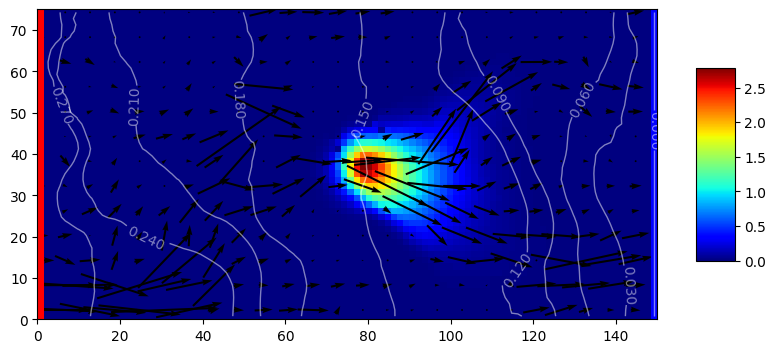

In [38]:
fig = plt.figure(figsize=(10, 5))
istep = 47
kstpkper = (istep, 0)
ml = fp.plot.PlotMapView(model=gwf, layer=4)
conc = ml.plot_array(gwt.output.concentration().get_data(kstpkper), cmap="jet")
plt.colorbar(conc, shrink=0.5, aspect=5)

cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)
cont = ml.contour_array(gwf.output.head().get_data((0 ,0)), levels=10, colors="white", linewidths=1, alpha=.5)
# display head values on contour lines
plt.clabel(cont, fmt="%.3f")

ml.plot_vector(qx, qy, normalize=False, istep=4, jstep=4)
ml.plot_bc("CHD-1", color="red")
ml.plot_bc("CHD-2", color="blue")
ml.plot_bc("WEL-INJ", color="green")
# ml.plot_bc("WEL-PROD", color="orange")

Text(0, 0.5, 'total concentration [g]')

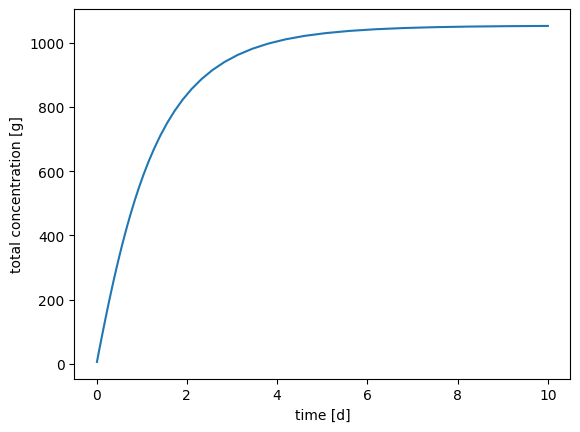

In [39]:
# plot evolution of total concentration over time
c = gwt.output.concentration().get_alldata()
c[c>100] = 0  # remove values from nan regions
plt.plot(np.array(gwt.output.concentration().times)/86400, c.sum(axis=(1, 2, 3)))
plt.xlabel("time [d]")
plt.ylabel("total concentration [g]")

In [41]:
pv.set_jupyter_backend("static")

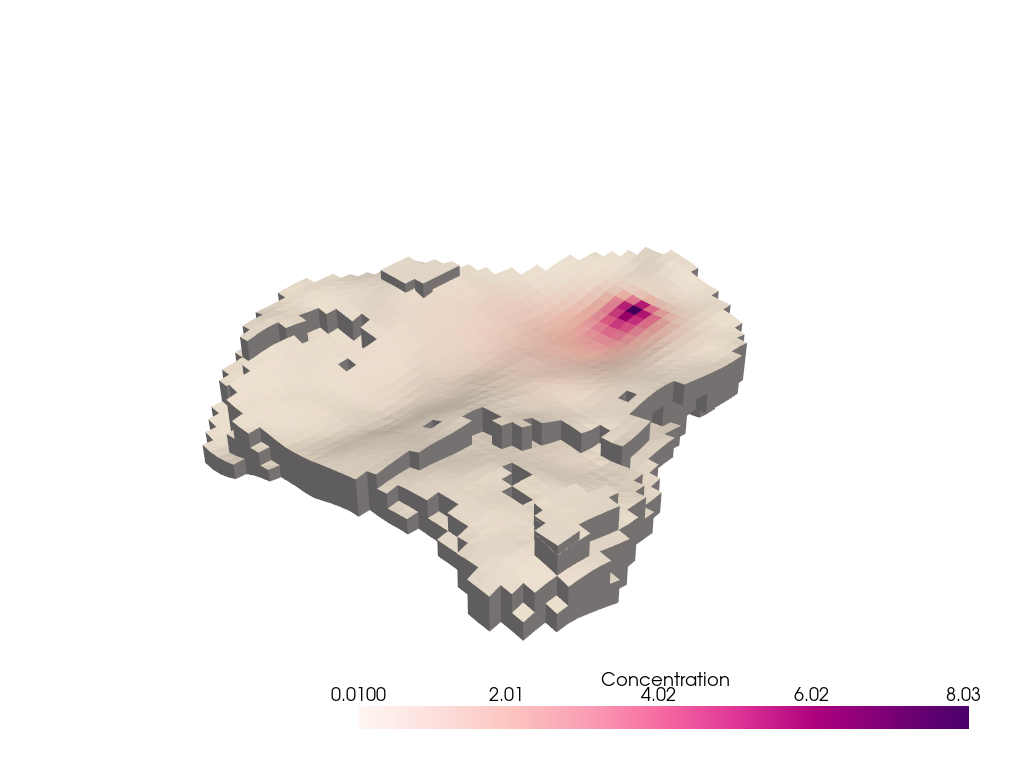

In [54]:
from flopy.export.vtk import Vtk

vert_exag = 2
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

heads = archpy_flow.get_heads()
vtk.add_array(gwt.output.concentration().get_alldata()[-1], name="Concentration")
vtk.add_array(np.log10(gwf.npf.k.array), name="K")

gwf_mesh = vtk.to_pyvista()
ghosts = np.argwhere(gwf_mesh["idomain"] <= 0)
gwf_mesh.remove_cells(ghosts, inplace=True)
ghosts = np.argwhere(gwf_mesh["Concentration"] <= 0.01)
gwf_mesh.remove_cells(ghosts, inplace=True)

pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=False, scalars="Concentration", cmap="RdPu")
# pl.show(screenshot="../../../figures/articles/archpy 2/raw/contaminant_sim.png", window_size=[1300, 900], auto_close=False)
pl.show()